In [56]:
!pip install tensorflow
!pip install keras


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [57]:
import tensorflow as tf
from tensorflow.keras import models,layers
from tensorflow.keras.layers import Resizing, Rescaling
import matplotlib.pyplot as plt

'tensorflow' is not recognized as an internal or external command,
operable program or batch file.


In [58]:
BATCH_SIZE = 32
IMAGE_SIZE = 255
CHANNEL = 3
EPOCHS = 20

In [59]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
directory='Potato',
seed=123,
shuffle = True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size = BATCH_SIZE
)

Found 1500 files belonging to 3 classes.


In [60]:
class_names = dataset.class_names
class_names

['Test', 'Train', 'Valid']

In [61]:
for image_batch,label_batch in dataset.take(1):
    print("Image Batch Shape : ", image_batch.shape)
    print("Single Image : ", image_batch[0])
    print("Label Image numpy : ", label_batch.numpy)

Image Batch Shape :  (32, 255, 255, 3)
Single Image :  tf.Tensor(
[[[152.98824  141.98824  157.98824 ]
  [150.98433  139.98433  155.98433 ]
  [148.98822  137.98822  153.98822 ]
  ...
  [149.01173  141.01173  156.01173 ]
  [151.98434  143.98434  158.98434 ]
  [154.99414  146.99414  161.99414 ]]

 [[148.98824  137.98824  153.98824 ]
  [148.98238  137.98238  153.98238 ]
  [147.98442  136.98442  152.98442 ]
  ...
  [150.00583  142.00583  157.00583 ]
  [152.9824   144.9824   159.9824  ]
  [154.9961   146.9961   161.9961  ]]

 [[147.00983  136.00983  152.00983 ]
  [147.0196   136.0196   152.0196  ]
  [147.02933  136.02933  152.02933 ]
  ...
  [151.00981  143.00981  158.00981 ]
  [152.98837  144.98837  159.98837 ]
  [154.98631  146.98631  161.98631 ]]

 ...

 [[112.0509   104.0509   117.0509  ]
  [113.0118   105.0118   118.0118  ]
  [110.01977  102.01977  115.01977 ]
  ...
  [146.77507  139.77507  147.77507 ]
  [142.09726  135.09726  143.09726 ]
  [147.02948  140.02948  148.02948 ]]

 [[109.0

In [62]:
len(class_names)

3

# Visualize some of the images from our dataset

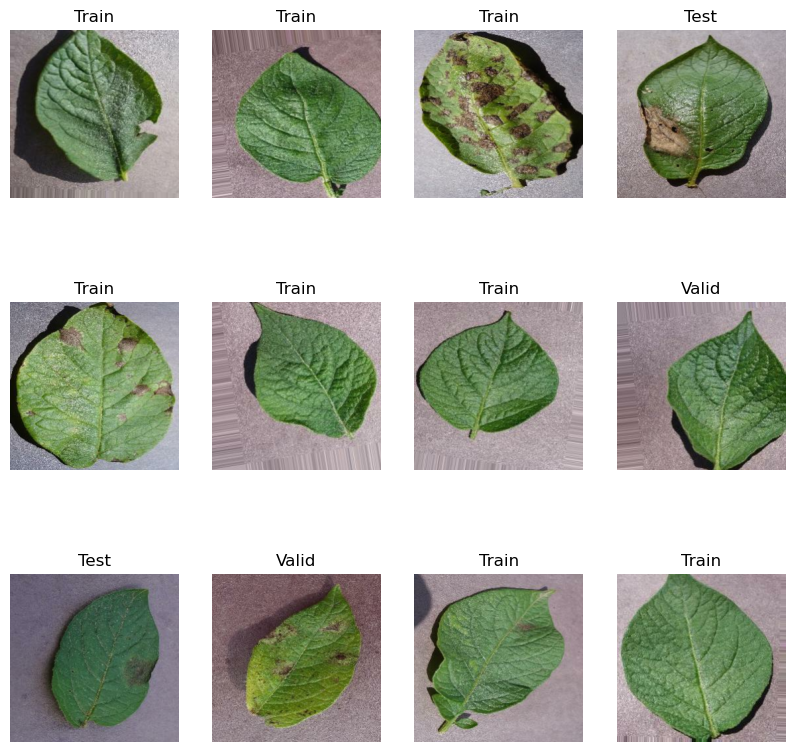

In [63]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    # Code to process the first batch of images and labels
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [64]:
len(dataset)

47

In [65]:
train_size = 0.8
len(dataset) * train_size

37.6

In [66]:
train_ds = dataset.take(54)
len(train_ds)

47

In [67]:
test_ds = dataset.skip(54)
len(test_ds)

0

In [68]:
val_size = 0.1
len(dataset)*val_size

4.7

In [69]:
val_ds = test_ds.take(6)
len(val_ds)

0

In [70]:
test_ds = test_ds.skip(6)
len(test_ds)

0

In [71]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [72]:
len(train_ds)

37

In [73]:
len(val_ds)

4

In [74]:
len(test_ds)

6

# Cache, Shuffle, and Prefetch the Dataset
additional transformations is commonly used in TensorFlow to optimize the performance of the input pipeline when training machine learning models

In [75]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [76]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.Rescaling(1./255),
])

# Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [77]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])

# Applying Data Augmentation to Train Dataset

In [78]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [79]:
model = models.Sequential([
    tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNEL)),  # Define input layer
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [80]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)            │ (None, 255, 255, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 253, 253, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 126, 126, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 124, 124, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

# Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [81]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [82]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.5588 - loss: 0.9949 - val_accuracy: 0.5938 - val_loss: 0.9567
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.5921 - loss: 0.9630 - val_accuracy: 0.5938 - val_loss: 0.9832
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.6317 - loss: 0.9546 - val_accuracy: 0.5938 - val_loss: 0.9572
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.6158 - loss: 0.9419 - val_accuracy: 0.5938 - val_loss: 0.9597
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.5962 - loss: 0.9542 - val_accuracy: 0.5938 - val_loss: 0.9706
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.6208 - loss: 0.9283 - val_accuracy: 0.5938 - val_loss: 0.9561
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.6149 - loss: 0.9359 - val_accuracy: 0.5938 - val_loss: 0.9551
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.6057 - loss: 0.9426 - val_accuracy: 0.5938 - val_loss:

In [83]:
scores = model.evaluate(test_ds)

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 349ms/step - accuracy: 0.6394 - loss: 0.9134


In [84]:
model.save("model.h5")

# Plotting the Accuracy and Loss Curves

In [85]:
print(history)
print(history.params)
print(history.history.keys())

{'verbose': 1, 'epochs': 20, 'steps': 37}
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [86]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9735757112503052,
 0.9503937363624573,
 0.9622507095336914,
 0.9574663639068604,
 0.9460674524307251]

In [87]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

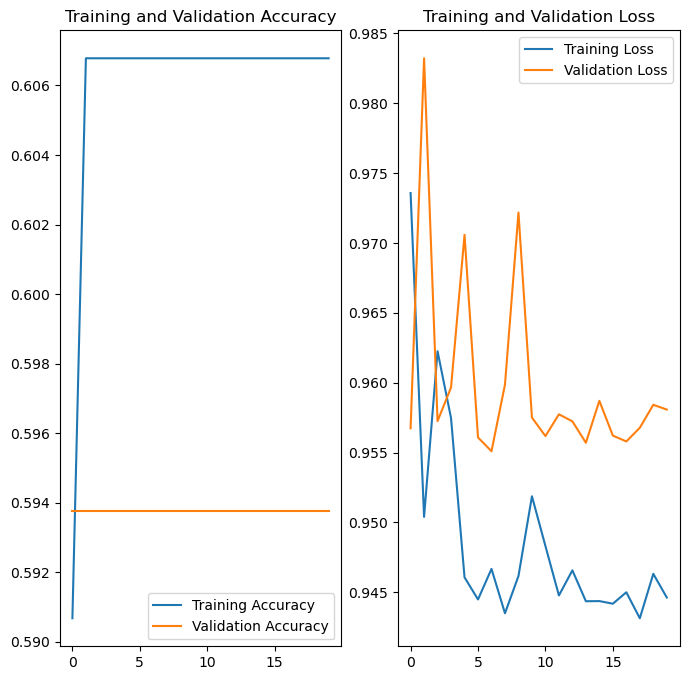

In [88]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Run prediction on a sample image

In [89]:
model = tf.keras.models.load_model('model.h5')

first image to predict
actual label: Test
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
predicted label: Train


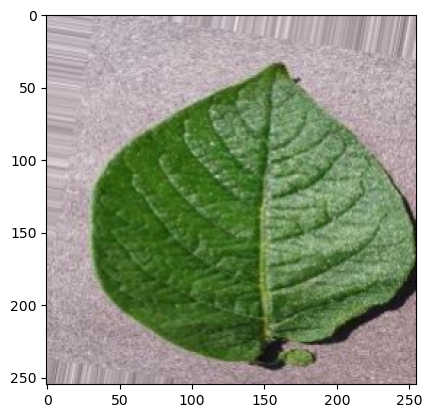

In [90]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# Write a function for inference

In [91]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


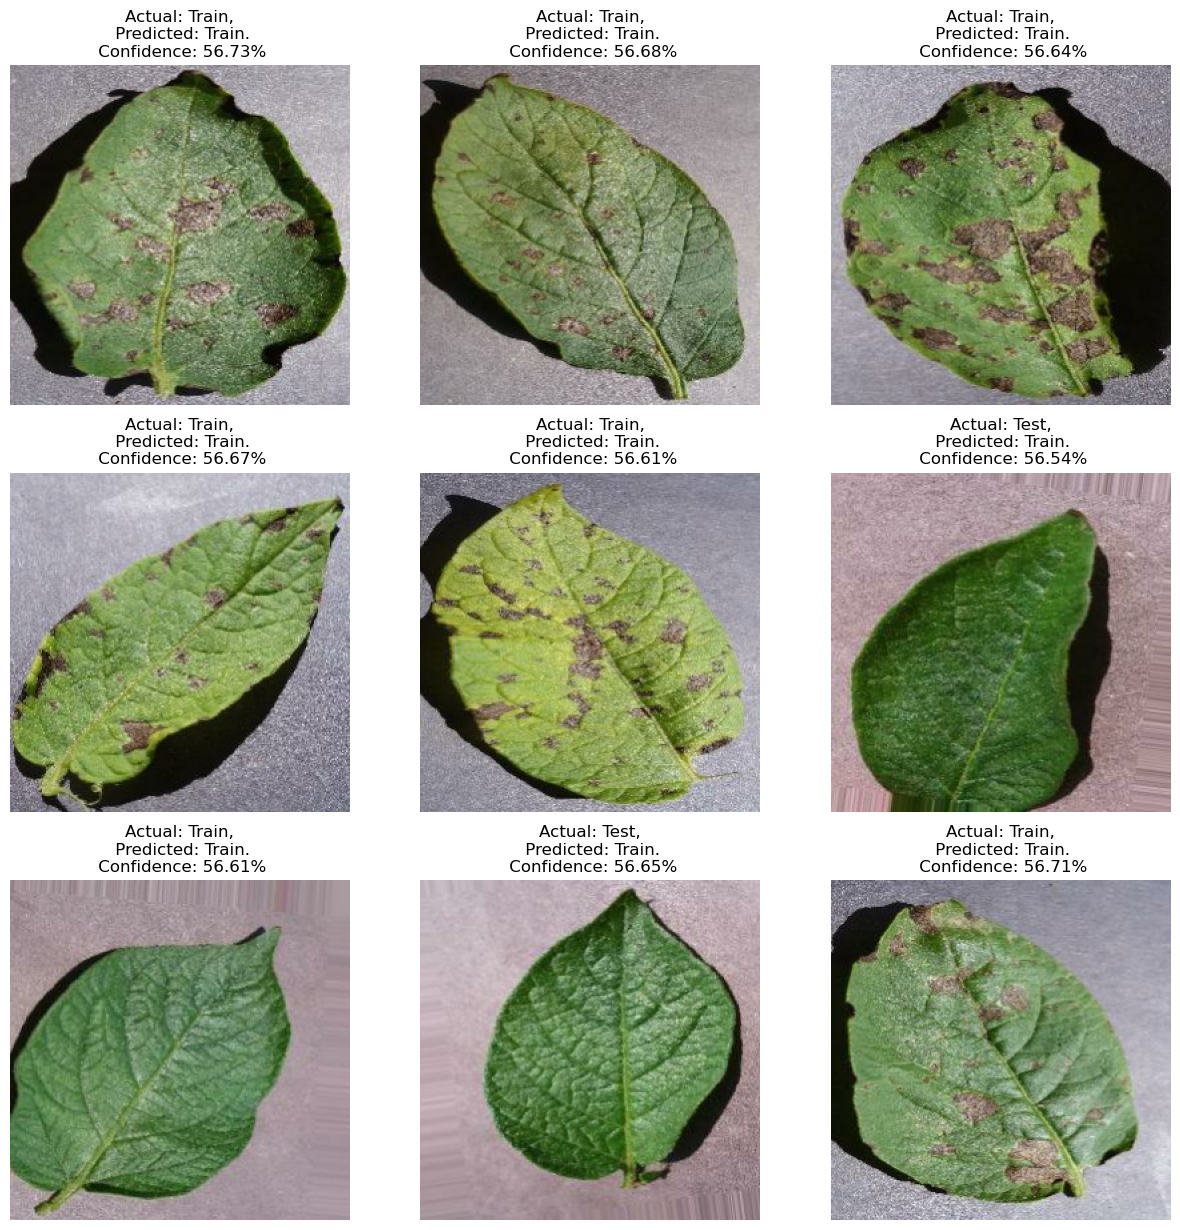

In [92]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")